# A/B-тестирование

## Описание цели и постановка задачи

Оценить корректность проведения теста и проанализировать его результаты.

Чтобы оценить корректность проведения теста:
- Нужно удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно;
- Проверить равномерность распределения пользователей по тестовым группам и правильность их формирования.


**Техническое задание**

- Название теста: `recommender_system_test` ;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: `2020-12-07`;
- дата остановки набора новых пользователей: `2020-12-21`;
- дата остановки: `2021-01-04`;
- аудитория: в тест должно быть отобрано `15%` новых пользователей из региона `EU`;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page` ,
    - просмотры корзины — `product_cart` ,
    - покупки — `purchase` .
    
    
**Данные**

Датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

- `final_ab_events.csv`
- `ab_project_marketing_events.csv`
- `final_ab_new_users.csv`
- `final_ab_participants.csv`

**Описание данных**
`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.
Структура файла:
- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.


`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года.
Структура файла:
- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.


`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.
Структура файла:
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок,`purchase`, в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.
Структура файла:
- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.



**Декомпозиция:**
1. Описание цели и постановка задачи
2. Исследование данных
      - 2.1 Обзор основной информации о датафреймах, преобразование типов, описание природы пропусков и дубликатов
3. Оценка корректности проведения теста
      - 3.1 Соответствуют ли данные требованиям ТЗ. Проверка корректности всех пунктов технического задания.
      - 3.2 Время проведения теста. Убедиться, что оно не совпадает с маркетинговыми и другими активностями.¶
      - 3.3 Аудиторию теста. Удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверьте равномерность распределения по тестовым группам и правильность их формирования.
4. Исследовательский анализ данных
      - 4.1 Количество событий на пользователя одинаково распределены в выборках?
      - 4.2 Как число событий в выборках распределено по дням?
      - 4.3 Как меняется конверсия в воронке в выборках на разных этапах?
5. Оценка результатов А/В - тестирования
      - 5.1 Проверка статистической разницы долей z-критерием
6. Выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Сделайте общее заключение о корректности проведения теста. 


## Исследование данных
### Обзор основной информации о датафреймах, преобразование типов, описание природы пропусков и дубликатов


In [95]:
import pandas as pd
import math as mth
import matplotlib.pyplot as plt 
from plotly import graph_objects as go
from scipy import stats as st
import numpy as np

In [96]:
try:
    final_ab_events = pd.read_csv('final_ab_events.csv', parse_dates=['event_dt'])
    ab_project_marketing_events = pd.read_csv('ab_project_marketing_events.csv', parse_dates=['start_dt','finish_dt'])
    final_ab_new_users = pd.read_csv('final_ab_new_users.csv', parse_dates=['first_date'])
    final_ab_participants = pd.read_csv('final_ab_participants.csv')
except:
    final_ab_events = pd.read_csv('/datasets/final_ab_events.csv', parse_dates=['event_dt'])
    ab_project_marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv', parse_dates=['start_dt','finish_dt'])
    final_ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv', parse_dates=['first_date'])
    final_ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')

In [97]:
def information(data):
    display(data.head())
    data.info()
    print('количество явных дубликатов')
    print(data.duplicated().sum())
    print('доля пропусков по всем столбцам')
    display(pd.DataFrame(round(data.isna().mean()*100, 1)).style.background_gradient('coolwarm'))

In [98]:
information(final_ab_events)
final_ab_events.describe()


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB
количество явных дубликатов
0
доля пропусков по всем столбцам


,0
user_id,0.000000
event_dt,0.000000
event_name,0.000000
details,85.800000


,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


In [99]:
print('Все уникальные значения столбца event_name\n')
print(final_ab_events['event_name'].unique())
print('\n\nКоличество строк с значением purchase в столбце event_name')
print("\n",len(final_ab_events.query('event_name == "purchase"')))
print('\n\nДоля пропусков в выборке с значением purchase в столбце event_name')
pd.DataFrame(round((final_ab_events.query('event_name == "purchase"')).isna().mean()*100, 1)).style.background_gradient('coolwarm')

Все уникальные значения столбца event_name

['purchase' 'product_cart' 'product_page' 'login']


Количество строк с значением purchase в столбце event_name

 62740


Доля пропусков в выборке с значением purchase в столбце event_name


,0
user_id,0.000000
event_dt,0.000000
event_name,0.000000
details,0.000000


В `final_ab_events` всего 440317 строк,отсутствуют явные дубликаты, имеются пропуски в столбце `details` - 85.8%, это обусловлено тем, что данный столбец заполнен только в строках c значением `purchase` в столбце `event_name`

In [100]:
information(ab_project_marketing_events)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
количество явных дубликатов
0
доля пропусков по всем столбцам


,0
name,0.000000
regions,0.000000
start_dt,0.000000
finish_dt,0.000000


В `ab_project_marketing_events` всего 14 строк, отсутствуют явные дубликаты, отсутствуют пропуски

In [101]:
information(final_ab_new_users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB
количество явных дубликатов
0
доля пропусков по всем столбцам


,0
user_id,0.000000
first_date,0.000000
region,0.000000
device,0.000000


В `final_ab_new_users` всего 61733  строк, отсутствуют явные дубликаты, отсутствуют пропуски

In [102]:
information(final_ab_participants)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
количество явных дубликатов
0
доля пропусков по всем столбцам


,0
user_id,0.000000
group,0.000000
ab_test,0.000000


В `final_ab_participants` всего 18268 строк, отсутствуют явные дубликаты, отсутствуют пропуски

## Оценка корректности проведения теста
### Соответствуют ли данные требованиям ТЗ. Проверка корректности всех пунктов технического задания.


- Проверим название теста, должно быть `recommender_system_test`

In [103]:
final_ab_participants['ab_test'].unique().tolist()

['recommender_system_test', 'interface_eu_test']

всего было проведерно 2  теста:
- `recommender_system_test`
- `interface_eu_test`


Посмотрим дату остановки набора именно данного теста `recommender_system_test`. Для этого объединим таблицы `final_ab_participants` с `final_ab_new_users` и нужным тестом. И посмотрим на окончание теста, соответствует ли оно заданию?

In [104]:
datafr = final_ab_participants.merge(final_ab_new_users)
datafr = datafr.query('ab_test == "recommender_system_test"')

In [105]:
datafr.head()

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
4,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
6,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC


In [106]:
print('дата запуска - ', datafr['first_date'].min())
print('дата остановки набора новых пользователей - ', datafr['first_date'].max())

дата запуска -  2020-12-07 00:00:00
дата остановки набора новых пользователей -  2020-12-21 00:00:00


- дата запуска: `2020-12-07`;
- дата остановки набора новых пользователей: `2020-12-21`;

Соответствует ТЗ

так как нас интересуют данные только c `recommender_system_test`, создадим отдельный датафрейм `final_recommender_system_test` с таким названием теста

In [107]:
final_recommender_system_test = final_ab_participants.query(' ab_test == "recommender_system_test"')
final_recommender_system_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6701 entries, 0 to 6700
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  6701 non-null   object
 1   group    6701 non-null   object
 2   ab_test  6701 non-null   object
dtypes: object(3)
memory usage: 209.4+ KB


- группы: А — контрольная, B — новая платёжная воронка;

In [108]:
final_recommender_system_test['group'].unique().tolist()

['A', 'B']

- дата запуска: `2020-12-07`;
- дата остановки набора новых пользователей: `2020-12-21`;

In [109]:
print('дата запуска - ', final_ab_new_users['first_date'].min())
print('дата остановки набора новых пользователей - ', final_ab_new_users['first_date'].max())

дата запуска -  2020-12-07 00:00:00
дата остановки набора новых пользователей -  2020-12-23 00:00:00


Не стыкуется, нужно избавиться от пользователей, зарегистрировавшихся после `2020-12-21`

In [110]:
final_ab_new_users = final_ab_new_users.query('first_date < = "2020-12-21"')

print('дата остановки набора новых пользователей - ', final_ab_new_users['first_date'].max())

дата остановки набора новых пользователей -  2020-12-21 00:00:00


- Действия новых пользователей в период с `7 декабря 2020 по 4 января 2021 года`

In [111]:
print(final_ab_events['event_dt'].min())
print(final_ab_events['event_dt'].max())

2020-12-07 00:00:33
2020-12-30 23:36:33


Оказались данные за период с 7го декабря по 30е число декабря, хотя по ТЗ должен быть диапазон с 7 декабря 2020 по 4 января 2021 года. Тест остановлен на 5 дней раньше, возможно были выгружены не все данные.

- аудитория: в тест должно быть отобрано `15%` новых пользователей из региона `EU`;
- ожидаемое количество участников теста: `6000`.

Рассмотрим количество 

In [112]:
final_ab_new_users['region'].value_counts()

EU           42340
N.America     8347
CIS           2900
APAC          2883
Name: region, dtype: int64

Создадим новый датафрейм `europe_region`, где соединим данные `final_recommender_system_test` с `final_ab_new_users` выбрав пользователей из EU

In [113]:
final_recommender_system_test.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [114]:
europe_region = (final_recommender_system_test.merge(final_ab_new_users.query('region == "EU"')[['user_id', 'region']].drop_duplicates(), how='left', on='user_id'))
europe_region.sample(n = 5)

,user_id,group,ab_test,region
3801,45914643E919B1BD,B,recommender_system_test,EU
1518,999E3FF7F8E5B295,B,recommender_system_test,EU
1382,757203C72510A549,A,recommender_system_test,EU
3042,4438A8DB1591E2FD,B,recommender_system_test,EU
2150,CC51FB594EA7240F,A,recommender_system_test,EU


In [115]:
europe_region['region'].unique()

array(['EU', nan], dtype=object)

In [116]:
europe_region = europe_region.dropna()

In [117]:
print('Количество участников - ', len(europe_region))

Количество участников -  6351


Посчитаем долю новых пользователей отфильтрованных по дате и региону `EU`

In [118]:
mth.trunc(len(europe_region) / final_ab_new_users.query('region == "EU"')['user_id'].nunique() *100)

15

в тесте отобрано 15% новых пользователей из региона EU, и количество участников 6351, что немного больше 6000. Оставим так. Далее, проверим время проведения теста и аудиторию

### Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.

Тест проводится с 7-го декабря 2020-го года до 4-го января 2021года, то есть мы должны сейчас найти маркетинговые активности, которые проводятся в это время

In [119]:
ab_project_marketing_events.query('start_dt >= "2020-12-07" & finish_dt <= "2021-01-04"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


В это время проводилось маркетинговое промо `Christmas&New Year Promo`, которое довольно сильно исказит результаты теста.

### Аудиторию теста. Удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверьте равномерность распределения по тестовым группам и правильность их формирования.

Сначала проверим наличие пользователей, которые учавствовали в конкурирующем тесте, а также рассмотрим пользователей учавствовавших в двух группах теста одновременно.

In [120]:
len(europe_region.merge( final_ab_participants.query('ab_test == "interface_eu_test"'), how = 'inner', on = 'user_id'))

1602

1602 пользователей учавствовали в двух разных тестах, рассмотрим долю от участников `recommender_system_test`

In [121]:
round(len(final_ab_participants.query('ab_test == "recommender_system_test"').merge( final_ab_participants.query('ab_test == "interface_eu_test"'), how = 'inner', on = 'user_id'))/len(europe_region) * 100, 2)

25.22

25.22% - доля пользователей учавствовавших в двух разных тестах.

Рассмотрим долю данных пользователей в разрезе групп тестирования

In [122]:
round((final_ab_participants.query('ab_test == "recommender_system_test"').merge( final_ab_participants.query('ab_test == "interface_eu_test"'), how = 'inner', on = 'user_id').groupby('group_x')['user_id'].count()/europe_region.groupby('group')['user_id'].count())*100, 2)

group_x
A    25.34
B    25.06
Name: user_id, dtype: float64

Распределение пользователей по тестовым группам почти одинаковая - 25.34% и 25.06%, поэтому будем считать что распределено равномерно.

Рассмотрим количество пользователей учавствовавших в двух группах теста одновременно

In [123]:
len(europe_region.query('group == "A"').merge( europe_region.query('group == "B"'), how = 'inner', on = 'user_id'))

0

Как оказалось, таких участников нет

- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
     - конверсии в просмотр карточек товаров — событие product_page ,
     - просмотры корзины — product_cart ,
     - покупки — purchase .
     
То есть нужно чтобы данные были не больше 14-ти дней

Для этого соединим датафрейм участников тестирования с датафреймом действия пользователей

In [124]:
event_users = europe_region.merge(final_ab_events, how='left', on='user_id')
event_users.head()

,user_id,group,ab_test,region,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,EU,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,EU,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,EU,2020-12-07 14:43:29,product_cart,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,EU,2020-12-25 00:04:57,product_cart,NaN
4,D1ABA3E2887B6A73,A,recommender_system_test,EU,2020-12-07 14:43:27,product_page,NaN


Добавим столбец с датой регстрации

In [125]:
event_users = event_users.merge(final_ab_new_users[['user_id', 'first_date']], how = 'left', on = 'user_id')
event_users.head()

,user_id,group,ab_test,region,event_dt,event_name,details,first_date
0,D1ABA3E2887B6A73,A,recommender_system_test,EU,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,EU,2020-12-25 00:04:56,purchase,4.99,2020-12-07
2,D1ABA3E2887B6A73,A,recommender_system_test,EU,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,EU,2020-12-25 00:04:57,product_cart,NaN,2020-12-07
4,D1ABA3E2887B6A73,A,recommender_system_test,EU,2020-12-07 14:43:27,product_page,NaN,2020-12-07


Добавим столбец высчитывающий день со дня регистрации и посчитаем количество строк не удовлетворяющих условию в рамках 14 дней.

In [126]:
event_users['days'] = event_users['event_dt'].dt.date - event_users['first_date'].dt.date 
event_users['days'] = event_users['days'].dt.days
event14 = event_users.query('days < 14')
len(event_users) - len(event14)

3670

Получилось что 3670 строк не входят 

## Исследовательский анализ данных
### Количество событий на пользователя одинаково распределены в выборках?

Рассчитаем среднее количество событий на одного пользователя

In [127]:
round(event14['event_name'].count()/event14['user_id'].nunique(), 0)

6.0

В среднем на одного пользователя приходитя 6 событий. Рассмотрим в разрезе групп тестирования

In [128]:
print('Среднее количество событий на пользователя в группе А')
round(event14.query('group == "A"')['event_name'].count()/event14.query('group == "A"')['user_id'].nunique(), 0)

Среднее количество событий на пользователя в группе А


7.0

In [129]:
print('Среднее количество событий на пользователя в группе В')
round(event14.query('group == "B"')['event_name'].count()/event14.query('group == "B"')['user_id'].nunique(), 0)

Среднее количество событий на пользователя в группе В


5.0

среднее количество событий на пользователя распределено : 
- для группы А - 7 событий
- для группы В - 5 событий

а по всем группам выходит - 6 событий

### Как число событий в выборках распределено по дням?

In [130]:
event14['event_dt'] = event14['event_dt'].dt.date
final_ab_new_users['first_date'] = final_ab_new_users['first_date'].dt.date

C:\Users\yum19\AppData\Local\Temp\ipykernel_14616\4055529133.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



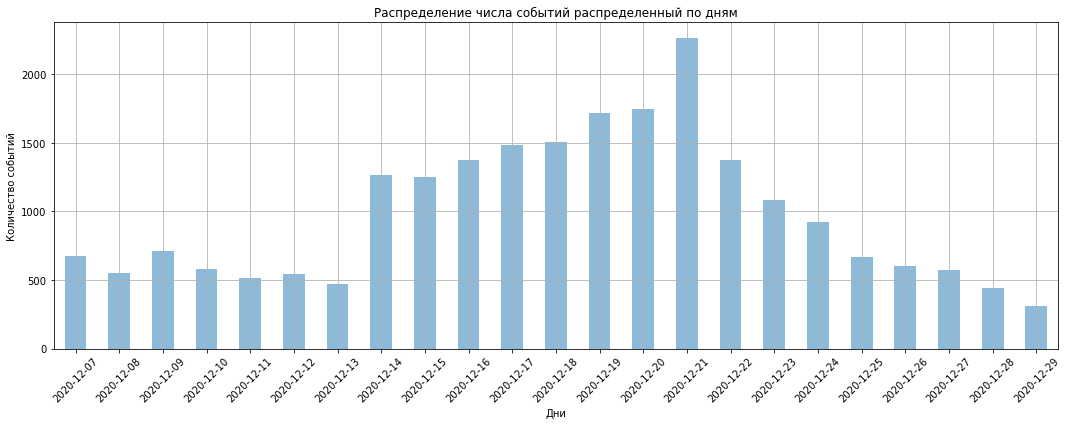

In [131]:

event14.groupby(['event_dt']).size().plot(kind='bar',  figsize=(18,6), alpha=0.5)
plt.xticks(rotation = 45)
plt.title('Распределение числа событий распределенный по дням')
plt.xlabel('Дни')
plt.ylabel('Количество событий')
plt.grid()
plt.show()
plt.show()

По результатам графика видим, что начиная с 14-го числа идет рост количества событий, доходит до 21-го числа и идет на спад. Скорее всего, это связано с покупками на рождественские праздники

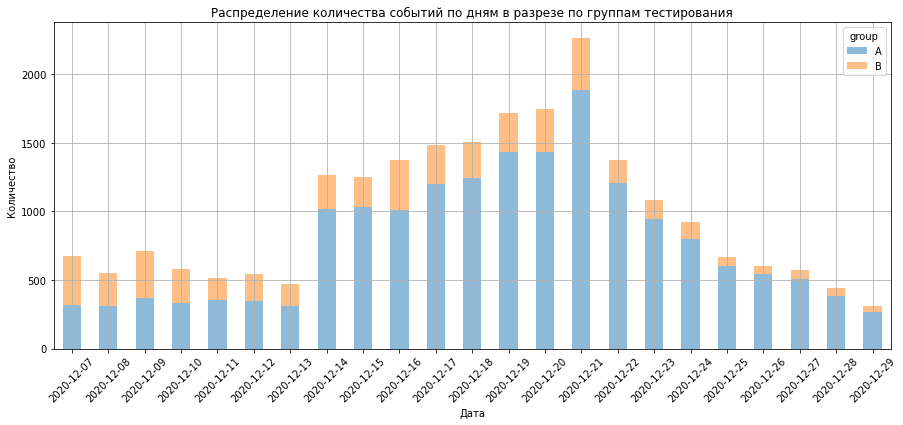

In [132]:
event14.groupby(['event_dt', 'group']).size().unstack().plot(kind='bar', stacked=True, figsize=(15,6), alpha = 0.5)
plt.xticks(rotation = 45)
plt.title('Распределение количества событий по дням в разрезе по группам тестирования')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.grid()

plt.show()

Доля количества событий до 14-го числа идет более-менее равномерно что в группе А, что в В. Далее видим резкий скачок 14-го числа, количество увеличивается и доходит до пика 21-го числа и далее идет на спад. Можно предположить, что доли групп А и В распределены по датам одинаково.

Рассмотрим динамику набора пользователей 

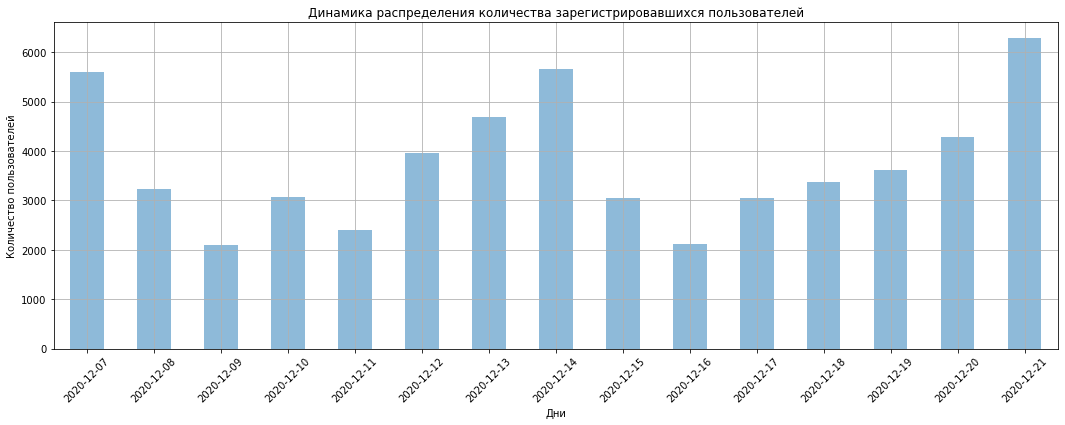

In [133]:
final_ab_new_users.groupby(['first_date']).size().plot(kind='bar',  figsize=(18,6), alpha=0.5)
plt.xticks(rotation = 45)
plt.title('Динамика распределения количества зарегистрировавшихся пользователей')
plt.xlabel('Дни')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()
plt.show()

в данном графике мы видим что на 14-е число приходится резкое увлечение набора пользователей
 

### Как меняется конверсия в воронке в выборках на разных этапах?

Рассмотрим количество событий по названиям событий:
- `login`        - входить в систему,
- `product_page` - просматривать карточки товаров,
- `product_cart` - просмотр корзины,
- `purchase`     - покупка 

Построим график воронки уникальных пользователей по двум группам вместе

In [134]:
fig = go.Figure(
    go.Funnel(
       y=[
            'login',
            'product_page',
            'product_cart',
            'purchase'
        ],
        x=[event14.query('event_name == "login"')['user_id'].nunique(), event14.query('event_name == "product_page"')['user_id'].nunique(), event14.query('event_name == "product_cart"')['user_id'].nunique(), event14.query('event_name == "purchase"')['user_id'].nunique()]
    ))
fig.update_layout(title='Воронка количества уникальных пользователей двух групп А и В')
fig.show() 

Видим, что `purchase` немного меньше, чем `product_cart`, возможно, скорее всего это связано с тем что некоторые товары покупают сразу не входя в корзину. Дальше рассмотрим такие же воронки для групп А и В отдельно


In [135]:
event14a = event14.query('group == "A"')
event14b = event14.query('group == "B"')

In [136]:
fig = go.Figure(
    go.Funnel(
       y=[
            'login',
            'product_page',
            'product_cart',
            'purchase'
        ],
        x=[event14a.query('event_name == "login"')['user_id'].nunique(), event14a.query('event_name == "product_page"')['user_id'].nunique(), event14a.query('event_name == "product_cart"')['user_id'].nunique(), event14a.query('event_name == "purchase"')['user_id'].nunique()]
    ))
fig.update_layout(title='Воронка количества событий группы А ')
fig.show() 

In [137]:
fig = go.Figure(
    go.Funnel(
       y=[
            'login',
            'product_page',
            'product_cart',
            'purchase'
        ],
        x=[event14b.query('event_name == "login"')['user_id'].nunique(), event14b.query('event_name == "product_page"')['user_id'].nunique(), event14b.query('event_name == "product_cart"')['user_id'].nunique(), event14b.query('event_name == "purchase"')['user_id'].nunique()]
    ))
fig.update_layout(title='Воронка количества событий группы В ')


fig.show() 

По результатам можем сказать, что в группе А, доля совершивших покупку из общего - `14.1%`, чуть-чуть больше чем в группе В - `13.4%`

Нужно помнить о том, что во время тестирования проводилось маркетинговое промо `Christmas&New Year Promo`


## Оценка результатов A/B-тестирования


### Проверка статистической разницы долей z-критерием.

Проверим статистическую разницу долей конверсии событий в тестируемых группах А и B

H0: Доли одинаковы

H1: Доли различаются

In [138]:
def hypot(value1, value2, event, alpha):
    
     # число пользователей в группе 1 и группе 2:
    n_users = np.array([value1['user_id'].nunique(), 
                        value2['user_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2
    success = np.array([value1[value1['event_name'] == event]['user_id'].nunique(), 
                        value2[value2['event_name'] == event]['user_id'].nunique()])

    df2_all_count = len(value2)

    # пропорция успехов в первой группе:
    p1 = success[0]/n_users[0]
    # пропорция успехов во второй группе    
    p2 = success[1]/n_users[1]
    
    print(success[0], success[1], n_users[0], n_users[1])

    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('Событие:', event)
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 

In [139]:
for event in ['login', 'product_page', 'product_cart', 'purchase']:
    hypot(event14.query('group == "A"'), event14.query('group == "B"'), event,.05)
    print()

2604 876 2604 877
Событие: login
p-значение:  0.08481837035887363
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1685 493 2604 877
Событие: product_page
p-значение:  6.942739359416805e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница

782 244 2604 877
Событие: product_cart
p-значение:  0.21469192029582396
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

833 249 2604 877
Событие: purchase
p-значение:  0.04652482738393027
Отвергаем нулевую гипотезу: между долями есть значимая разница



Конверсия событий в тестируемых группах А и B, доли событий `login`, `product_cart`, `purchase` - одинаковы, конверсии. Событие `product_page` в группах А и Б не равны.

## Выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Сделайте общее заключение о корректности проведения теста.

В результате, исходя из обнаруженных фактов, можно сказать что тест был проведен с нарушениями по ключевым параметрам, а именно:
- данные с 30-го декабря до 4 января 2021года, отсутствуют. Нарушение ТЗ
- одновременное проведение двух разных тестов, что привело к пользователям учавствовавших в двух тестах одновременно
- пересечение с маркетинговым промо во время тестирования
- данные набора новых пользователей идут до 21-го числа, как по ТЗ
- размер группы А больше чем В
- По результатам можем сказать, что в группе А, доля совершивших покупку из общего - `14.1%`, чуть-чуть больше чем в группе В - `13.4%`

Дальнейшие рекомендации:
Повтоное проведение теста, с строгим учетом пунктов ТЗ